# Merging volumentric ROI measures and freesurfer surface measures.
- Cortical thickness/volume/aseg/wmparc data generated by "../tab_data/freesurfer_stats2table.sh" from fMRIPrep_20.2.0 freesurfer_6.0.1
- Cerebellar segmetations in both SUIT34 and MDTB10 spaces.
- Uses participants data (../tab_data/PPMI_subjects.list ADNI_subjects.list) as target to join, all NaN values droped;
## Cohorts
- PPMI NC, ADNI2 NC
## Parcellations
- Distreux
- DKT
## Results
- Distreux: ../tab_data/ADNI-PPMI_Des-cere_preped.csv
- DKT:      ../tab_data/ADNI-PPMI_DKT-cere_preped.csv

In [1]:
## Preprocessing of ADNI and PPMI dataset freesurfer outputs
#lib and path
from pathlib import Path
import pandas as pd
import seaborn as sns
import numpy as np
data_dir = Path("/codes/tab_data")
adni_list_file = data_dir/'ADNI_subjects.list'
ppmi_list_file = data_dir/'PPMI_subjects.list'
ppmi_site_file = data_dir/'PPMI_Center-Subject-List_Yashar.csv'
# groups
GROUPS   = ['ADNI', 'PPMI']
n_groups = len(GROUPS)
sub_list_file = [data_dir/(x+'_subjects.list') for x in GROUPS]
sub_list = [pd.read_csv(x, sep='\t', header=0, index_col=0) for x in sub_list_file]

# reading freesurfer results
FS_DIR = data_dir/'freesurfer_output_20.2.0'
group_data={};

# output file
res_file = [data_dir/'ADNI-PPMI_Des-cere_preped.csv', data_dir/'ADNI-PPMI_DKT-cere_preped.csv']
combined_res_file = [data_dir/'freesurfer_out_preped.csv']

files_2_read={'seg': ['aseg_stats.txt', 'wmparc_stats.txt'],
              'Destrieux': {'ct': '.a2009s.thickness.txt','area':'.a2009s.area.txt', 'volume':'.a2009s.volume.txt', 'meancurv':'.a2009s.meancurv.txt'},
              'DKT': {'ct': '.DKTatlas.thickness.txt','area':'.DKTatlas.area.txt', 'volume':'.DKTatlas.volume.txt', 'meancurv':'.DKTatlas.meancurv.txt'}}
# PPMI site information from Yashar
ppmi_site_df = pd.read_csv(ppmi_site_file,  usecols=[0,1], sep=',', header=0, names=['site','participant_id'], dtype={'site': np.str_, 'participant_id': np.str_}) 
ppmi_site_df['participant_id'] = [ 'sub-'+x for x in ppmi_site_df['participant_id']]
ppmi_site_df['site'] = ['ppmi_'+x for x in ppmi_site_df['site']]
ppmi_site_df.index=ppmi_site_df['participant_id']; ppmi_site_df=ppmi_site_df.drop(columns=['participant_id'],axis=1)

for i_group in range(n_groups):
    """
    Loop to gather all the freesurfer outputs for ET/PD/NC group.
    Output: all_data (dataframe).
    """
    print('Reading ' , GROUPS[i_group], ' freesurfer stats data...')
    # raw data path
    raw_data_path = FS_DIR/GROUPS[i_group]
    # segmentation
    subcortical_file = raw_data_path / (files_2_read['seg'][0]); wm_file = raw_data_path / 'wmparc_stats.txt'; 
    # Des parcellation
    lh_Des_ct_file = raw_data_path / ('lh'+files_2_read['Destrieux']['ct']);  rh_Des_ct_file = raw_data_path /  ('rh'+files_2_read['Destrieux']['ct']);
    lh_Des_vol_file = raw_data_path / ('lh'+files_2_read['Destrieux']['volume']); rh_Des_vol_file = raw_data_path / ('rh'+files_2_read['Destrieux']['volume']);
    lh_Des_area_file = raw_data_path / ('lh'+files_2_read['Destrieux']['area']); rh_Des_area_file = raw_data_path / ('rh'+files_2_read['Destrieux']['area']);
    lh_Des_meancurv_file = raw_data_path / ('lh'+files_2_read['Destrieux']['meancurv']); rh_Des_meancurv_file = raw_data_path / ('rh'+files_2_read['Destrieux']['meancurv']);
    # DKT parcellation
    lh_DKT_area_file = raw_data_path / ('lh'+files_2_read['DKT']['area']);       rh_DKT_area_file = raw_data_path / ('rh'+files_2_read['DKT']['area']);
    lh_DKT_ct_file = raw_data_path / ('lh'+files_2_read['DKT']['ct']);        rh_DKT_ct_file = raw_data_path /  ('rh'+files_2_read['DKT']['ct']);
    lh_DKT_vol_file = raw_data_path / ('lh'+files_2_read['DKT']['volume']);       rh_DKT_vol_file = raw_data_path / ('rh'+files_2_read['DKT']['volume']);
    lh_DKT_meancurv_file = raw_data_path / ('lh'+files_2_read['DKT']['meancurv']);       rh_DKT_meancurv_file = raw_data_path / ('rh'+files_2_read['DKT']['meancurv']);
    ## drop_list
    aseg_drop = ["EstimatedTotalIntraCranialVol"]; 
    wm_drop = ["MaskVol", "EstimatedTotalIntraCranialVol", "CerebralWhiteMatterVol", "rhCerebralWhiteMatterVol", "lhCerebralWhiteMatterVol"];
    parc_drop = ["BrainSegVolNotVent", "eTIV"]; 
    ##
    subcortical_tab = pd.read_csv(subcortical_file, sep='\t', header=0, index_col=0); 
    subcortical_tab['eTIV']=subcortical_tab['EstimatedTotalIntraCranialVol']
    subcortical_tab.drop(aseg_drop, axis=1, inplace=True);
    # add site and group info
    if GROUPS[i_group]=='ADNI':
        sub_list[i_group]['site']=['adni_'+x.split('S')[0][4:] for x in sub_list[i_group].index];
        sub_list[i_group]['group'] = GROUPS[i_group];
    elif GROUPS[i_group]=='PPMI':
        sub_list[i_group] = sub_list[i_group].join(ppmi_site_df, how='left')
        sub_list[i_group]['group'] = GROUPS[i_group];
    else:
        print("No site informatin added!!!")
    res = sub_list[i_group].join(subcortical_tab, how='left');
    wm_tab = pd.read_csv(wm_file, sep='\t', header=0, index_col=0); wm_tab.drop(wm_drop, axis=1, inplace=True);
    res1   = res.join(wm_tab, how='left');
    # read Des/DKT parcelation data
    lh_Des_ct_tab  = pd.read_csv(lh_Des_ct_file,  sep='\t', header=0, index_col=0); lh_Des_ct_tab.drop( parc_drop, axis=1, inplace=True);
    rh_Des_ct_tab  = pd.read_csv(rh_Des_ct_file,  sep='\t', header=0, index_col=0); rh_Des_ct_tab.drop( parc_drop, axis=1, inplace=True);
    lh_Des_vol_tab = pd.read_csv(lh_Des_vol_file, sep='\t', header=0, index_col=0); lh_Des_vol_tab.drop(parc_drop, axis=1, inplace=True);
    rh_Des_vol_tab = pd.read_csv(rh_Des_vol_file, sep='\t', header=0, index_col=0); rh_Des_vol_tab.drop(parc_drop, axis=1, inplace=True);
    lh_DKT_ct_tab  = pd.read_csv(lh_DKT_ct_file,  sep='\t', header=0, index_col=0); lh_DKT_ct_tab.drop( parc_drop, axis=1, inplace=True);
    rh_DKT_ct_tab  = pd.read_csv(rh_DKT_ct_file,  sep='\t', header=0, index_col=0); rh_DKT_ct_tab.drop( parc_drop, axis=1, inplace=True);
    lh_DKT_vol_tab = pd.read_csv(lh_DKT_vol_file, sep='\t', header=0, index_col=0); lh_DKT_vol_tab.drop(parc_drop, axis=1, inplace=True);
    rh_DKT_vol_tab = pd.read_csv(rh_DKT_vol_file, sep='\t', header=0, index_col=0); rh_DKT_vol_tab.drop(parc_drop, axis=1, inplace=True);
    # merge Des/DKT parcelation data
    seg_Des_tab=res1.join(lh_Des_ct_tab, how='left'); seg_Des_tab=seg_Des_tab.join(rh_Des_ct_tab, how='left'); seg_Des_tab=seg_Des_tab.join(lh_Des_vol_tab,how='left'); seg_Des_tab=seg_Des_tab.join(rh_Des_vol_tab,how='left'); 
    seg_DKT_tab=res1.join(lh_DKT_ct_tab, how='left'); seg_DKT_tab=seg_DKT_tab.join(rh_DKT_ct_tab, how='left'); seg_DKT_tab=seg_DKT_tab.join(lh_DKT_vol_tab,how='left'); seg_DKT_tab=seg_DKT_tab.join(rh_DKT_vol_tab,how='left'); 
    # return data
    group_data[GROUPS[i_group]]={'Des': seg_Des_tab, 'DKT':seg_DKT_tab}
all_data = {'Des': pd.concat([group_data['ADNI']['Des'], group_data['PPMI']['Des']]), 'DKT': pd.concat([group_data['ADNI']['DKT'], group_data['PPMI']['DKT']])}
for x in GROUPS:
    print(x , len(group_data[x]['Des']))
for k, v in all_data.items():
    v.index   = [x.replace('-','_') for x in v.index]
    v.columns = [x.replace('-','_') for x in v.columns]

Reading  ADNI  freesurfer stats data...
Reading  PPMI  freesurfer stats data...
ADNI 310
PPMI 116


In [2]:
##Fixing all the format problems: 1. All '-' are replaced by '_'; 
seg_col =[x.replace('-','_') for x in subcortical_tab.columns];
wm_col  =[x.replace('-','_') for x in wm_tab.columns]
lh_des_ct_col=[x.replace('-','_') for x in lh_Des_ct_tab.columns]; rh_des_ct_col=[x.replace('-','_') for x in rh_Des_ct_tab.columns];
lh_dkt_ct_col=[x.replace('-','_') for x in lh_DKT_ct_tab.columns]; rh_dkt_ct_col=[x.replace('-','_') for x in rh_DKT_ct_tab.columns];
lh_des_vol_col=[x.replace('-','_') for x in lh_Des_vol_tab.columns]; rh_des_vol_col=[x.replace('-','_') for x in rh_Des_vol_tab.columns];
lh_dkt_vol_col=[x.replace('-','_') for x in lh_DKT_vol_tab.columns]; rh_dkt_vol_col=[x.replace('-','_') for x in rh_DKT_vol_tab.columns];
import matplotlib.pyplot as plt

In [3]:
## adding cerebellar measures from SUIT software in both SUIT space and MDTB space.
# read SUIT space label
## this part of code need to be updated with the the new SUIT ADNI resutls.
adni_suit_list_file = data_dir/'ADNI_subjects.list'

suit_label_file=data_dir/'atlas'/'Lobules-SUIT.nii.lut'
suit_label_df  =pd.read_csv(suit_label_file, sep=' ', header=None, index_col=None); 
suit_label=suit_label_df.iloc[:,7];
suit_res_files = [data_dir/('res_'+x+'_SUIT34.csv') for x in GROUPS]
suit_res_dfs = [pd.read_csv(x, sep=',', header=None, index_col=None) for x in suit_res_files]
suit_drop_list=[[],[61]]; # cerebellar droplist for ADNI and PPMI

# read MDTB space
MDTB_res_files= [data_dir/('res_'+x+'_MDTB10.csv') for x in GROUPS]
MDTB_res_dfs  = [pd.read_csv(x, sep=',', header=None, index_col=None) for x in MDTB_res_files];
MDTB_label=['MDTB_'+str(x+1) for x in range(10)];
for i_group in range(n_groups):
    #suit_res_dfs[i_group]=suit_res_dfs[i_group].drop(axis=0,index=suit_drop_list[i_group])
    index_list=[x.replace('-','_') for x in group_data[GROUPS[i_group]]['Des'].index]
    suit_res_dfs[i_group].columns=suit_label; 
    suit_res_dfs[i_group].index=index_list;
    suit_res_dfs[i_group]['suit_total']=suit_res_dfs[i_group].sum(axis=1)
    #MDTB_res_dfs[i_group]=MDTB_res_dfs[i_group].drop(axis=0,index=suit_drop_list[i_group])
    MDTB_res_dfs[i_group].columns=MDTB_label
    MDTB_res_dfs[i_group].index=index_list;
    MDTB_res_dfs[i_group]['MDTB_total']=MDTB_res_dfs[i_group].sum(axis=1)
suit_merge=pd.concat(suit_res_dfs); MDTB_merge=pd.concat(MDTB_res_dfs);
cereb_merge=suit_merge.join(MDTB_merge, how='left');
all_data['Des'] = all_data['Des'].join(cereb_merge, how='left'); #all_data['Des']=all_data['Des'].dropna();
all_data['DKT'] = all_data['DKT'].join(cereb_merge, how='left'); #all_data['DKT']=all_data['DKT'].dropna();
suit_col =[x for x in suit_merge.columns]; mdtb_col =[x for x in MDTB_merge.columns];

In [4]:
# debuging for duplicates in ADNI subject list.
tmp_df = all_data['Des']
print(tmp_df[tmp_df['group']=='ADNI'].shape, tmp_df[tmp_df['group']=='PPMI'].shape)
print(suit_merge.shape, MDTB_merge.shape, cereb_merge.shape)

tmp_df = all_data['Des']
print(tmp_df[tmp_df['group']=='ADNI'].shape, tmp_df[tmp_df['group']=='PPMI'].shape)
print(len(tmp_df[tmp_df['group']=='ADNI'].index.unique()), len(tmp_df[tmp_df['group']=='PPMI'].index.unique()))
#tmp_df[tmp_df['group']=='ADNI'].index.duplicated()

tmp_merge=suit_merge.join(MDTB_merge);
m_index=sorted(tmp_merge.index.unique())
s_index=sorted(suit_merge.index.unique())
tmp_df = all_data['Des']
tmp_adni=tmp_df[tmp_df['group']=='ADNI'];
tmp_ppmi=tmp_df[tmp_df['group']=='PPMI'];
print(len(tmp_adni.index),len(tmp_ppmi.index))
print(len(tmp_adni.index.unique()),len(tmp_ppmi.index.unique()))
#print(len(suit_merge.index),len(suit_merge.index.unique()) )
#for x in range(len(m_index)):
#    print(x)
#    if m_index[x]!=s_index[x]:
#        print(m_index[x], s_index[x])
#print(m_index,s_index)
# 8, 'sub_002S4264'
for i_ in range(len(tmp_adni.index.duplicated())):
    if tmp_adni.index.duplicated()[i_]==True:
        print(i_, tmp_adni.index[i_])
# 8 sub_002S4264 : 8, 226 in subject.list
# 274 sub_130S0969 : 202, 298 in subject.list;
# 278 sub_131S0123 : 203, 301 in subject.list

(310, 484) (116, 484)
(426, 35) (426, 11) (426, 46)
(310, 484) (116, 484)
310 116
310 116
310 116


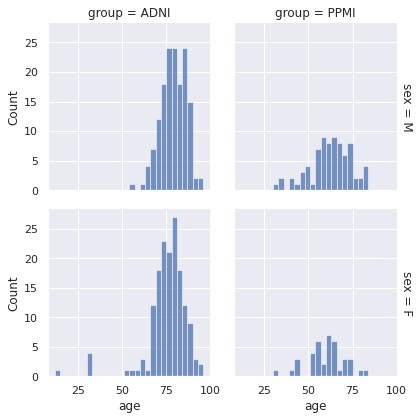

In [5]:
#plot age/sex/diagnosis group 2*3
sns.set_theme(style="darkgrid")
sns.displot(
    all_data['Des'], x="age", col="group", row="sex", 
    binwidth=3, height=3, facet_kws=dict(margin_titles=True))

In [6]:
# display all the brain measure variable names 
SUIT_labels =['Left_I_IV','Right_I_IV','Left_V','Right_V','Left_VI','Vermis_VI','Right_VI','Left_CrusI','Vermis_CrusI','Right_CrusI','Left_CrusII','Vermis_CrusII','Right_CrusII','Left_VIIb','Vermis_VIIb','Right_VIIb','Left_VIIIa','Vermis_VIIIa','Right_VIIIa','Left_VIIIb','Vermis_VIIIb','Right_VIIIb','Left_IX','Vermis_IX','Right_IX','Left_X','Vermis_X','Right_X','Left_Dentate','Right_Dentate','Left_Interposed','Right_Interposed','Left_Fastigial','Right_Fastigial'];
SUIT_labels = [ x.replace('-','_') for x in SUIT_labels]
SUIT_l_labels =['Left_I_IV',  'Left_V', 'Left_VI', 'Left_CrusI', 'Left_CrusII', 'Left_VIIb', 'Left_VIIIa', 'Left_VIIIb', 'Left_IX', 'Left_X', 'Left_Dentate', 'Left_Interposed', 'Left_Fastigial'];
SUIT_r_labels =['Right_I_IV','Right_V','Right_VI','Right_CrusI','Right_CrusII','Right_VIIb','Right_VIIIa','Right_VIIIb','Right_IX','Right_X','Right_Dentate','Right_Interposed','Right_Fastigial'];
SUIT_v_labels =['Vermis_VI', 'Vermis_CrusI', 'Vermis_CrusII', 'Vermis_VIIb', 'Vermis_VIIIa','Vermis_VIIIb', 'Vermis_IX', 'Vermis_X'];
MDTB_labels  =['MDTB_'+str(x+1) for x in range(10)];
Des_labels   =['_G&S_frontomargin_thickness', '_G&S_occipital_inf_thickness', '_G&S_paracentral_thickness', '_G&S_subcentral_thickness', '_G&S_transv_frontopol_thickness', '_G&S_cingul-Ant_thickness', '_G&S_cingul-Mid-Ant_thickness', '_G&S_cingul-Mid-Post_thickness', '_G_cingul-Post-dorsal_thickness', '_G_cingul-Post-ventral_thickness', '_G_cuneus_thickness', '_G_front_inf-Opercular_thickness', '_G_front_inf-Orbital_thickness', '_G_front_inf-Triangul_thickness', '_G_front_middle_thickness', '_G_front_sup_thickness', '_G_Ins_lg&S_cent_ins_thickness', '_G_insular_short_thickness', '_G_occipital_middle_thickness', '_G_occipital_sup_thickness', '_G_oc-temp_lat-fusifor_thickness', '_G_oc-temp_med-Lingual_thickness', '_G_oc-temp_med-Parahip_thickness', '_G_orbital_thickness', '_G_pariet_inf-Angular_thickness', '_G_pariet_inf-Supramar_thickness', '_G_parietal_sup_thickness', '_G_postcentral_thickness', '_G_precentral_thickness', '_G_precuneus_thickness', '_G_rectus_thickness', '_G_subcallosal_thickness', '_G_temp_sup-G_T_transv_thickness', '_G_temp_sup-Lateral_thickness', '_G_temp_sup-Plan_polar_thickness', '_G_temp_sup-Plan_tempo_thickness', '_G_temporal_inf_thickness', '_G_temporal_middle_thickness', '_Lat_Fis-ant-Horizont_thickness', '_Lat_Fis-ant-Vertical_thickness', '_Lat_Fis-post_thickness', '_Pole_occipital_thickness', '_Pole_temporal_thickness', '_S_calcarine_thickness', '_S_central_thickness', '_S_cingul-Marginalis_thickness', '_S_circular_insula_ant_thickness', '_S_circular_insula_inf_thickness', '_S_circular_insula_sup_thickness', '_S_collat_transv_ant_thickness', '_S_collat_transv_post_thickness', '_S_front_inf_thickness', '_S_front_middle_thickness', '_S_front_sup_thickness', '_S_interm_prim-Jensen_thickness', '_S_intrapariet&P_trans_thickness', '_S_oc_middle&Lunatus_thickness', '_S_oc_sup&transversal_thickness', '_S_occipital_ant_thickness', '_S_oc-temp_lat_thickness', '_S_oc-temp_med&Lingual_thickness', '_S_orbital_lateral_thickness', '_S_orbital_med-olfact_thickness', '_S_orbital-H_Shaped_thickness', '_S_parieto_occipital_thickness', '_S_pericallosal_thickness', '_S_postcentral_thickness', '_S_precentral-inf-part_thickness', '_S_precentral-sup-part_thickness', '_S_suborbital_thickness', '_S_subparietal_thickness', '_S_temporal_inf_thickness', '_S_temporal_sup_thickness', '_S_temporal_transverse_thickness', '_MeanThickness_thickness']
Des_labels = [ x.replace('-','_') for x in Des_labels]
Des_l_labels =['lh'+x for x in Des_labels]; Des_r_labels=['rh'+x for x in Des_labels]
DKT_labels   =['_caudalanteriorcingulate_thickness', '_caudalmiddlefrontal_thickness', '_cuneus_thickness', '_entorhinal_thickness', '_fusiform_thickness', '_inferiorparietal_thickness', '_inferiortemporal_thickness', '_isthmuscingulate_thickness', '_lateraloccipital_thickness', '_lateralorbitofrontal_thickness', '_lingual_thickness', '_medialorbitofrontal_thickness', '_middletemporal_thickness', '_parahippocampal_thickness', '_paracentral_thickness', '_parsopercularis_thickness', '_parsorbitalis_thickness', '_parstriangularis_thickness', '_pericalcarine_thickness', '_postcentral_thickness', '_posteriorcingulate_thickness', '_precentral_thickness', '_precuneus_thickness', '_rostralanteriorcingulate_thickness', '_rostralmiddlefrontal_thickness', '_superiorfrontal_thickness', '_superiorparietal_thickness', '_superiortemporal_thickness', '_supramarginal_thickness', '_transversetemporal_thickness', '_insula_thickness', '_MeanThickness_thickness'];
DTK_l_labels =['lh'+x for x in DKT_labels]; DTK_r_labels=['rh'+x for x in DKT_labels]
aseg_labels  =['Left_Lateral_Ventricle', 'Left_Inf_Lat_Vent', 'Left_Cerebellum_White_Matter', 'Left_Cerebellum_Cortex', 'Left_Thalamus_Proper', 'Left_Caudate', 'Left_Putamen', 'Left_Pallidum', '3rd_Ventricle', '4th_Ventricle', 'Brain_Stem', 'Left_Hippocampus', 'Left_Amygdala', 'CSF', 'Left_Accumbens_area', 'Left_VentralDC', 'Left_vessel', 'Left_choroid_plexus', 'Right_Lateral_Ventricle', 'Right_Inf_Lat_Vent', 'Right_Cerebellum_White_Matter', 'Right_Cerebellum_Cortex', 'Right_Thalamus_Proper', 'Right_Caudate', 'Right_Putamen', 'Right_Pallidum', 'Right_Hippocampus', 'Right_Amygdala', 'Right_Accumbens_area', 'Right_VentralDC', 'Right_vessel', 'Right_choroid_plexus', '5th_Ventricle', 'WM_hypointensities', 'Left_WM_hypointensities', 'Right_WM_hypointensities', 'non_WM_hypointensities', 'Left_non_WM_hypointensities', 'Right_non_WM_hypointensities', 'Optic_Chiasm', 'CC_Posterior', 'CC_Mid_Posterior', 'CC_Central', 'CC_Mid_Anterior', 'CC_Anterior', 'BrainSegVol', 'BrainSegVolNotVent', 'BrainSegVolNotVentSurf', 'lhCortexVol', 'rhCortexVol', 'CortexVol', 'lhCerebralWhiteMatterVol', 'rhCerebralWhiteMatterVol', 'CerebralWhiteMatterVol', 'SubCortGrayVol', 'TotalGrayVol', 'SupraTentorialVol', 'SupraTentorialVolNotVent', 'SupraTentorialVolNotVentVox', 'MaskVol', 'BrainSegVol_to_eTIV', 'MaskVol_to_eTIV', 'lhSurfaceHoles', 'rhSurfaceHoles', 'SurfaceHoles', 'EstimatedTotalIntraCranialVol']
wmparc_labels=['wm_lh_bankssts', 'wm_lh_caudalanteriorcingulate', 'wm_lh_caudalmiddlefrontal', 'wm_lh_cuneus', 'wm_lh_entorhinal', 'wm_lh_fusiform', 'wm_lh_inferiorparietal', 'wm_lh_inferiortemporal', 'wm_lh_isthmuscingulate', 'wm_lh_lateraloccipital', 'wm_lh_lateralorbitofrontal', 'wm_lh_lingual', 'wm_lh_medialorbitofrontal', 'wm_lh_middletemporal', 'wm_lh_parahippocampal', 'wm_lh_paracentral', 'wm_lh_parsopercularis', 'wm_lh_parsorbitalis', 'wm_lh_parstriangularis', 'wm_lh_pericalcarine', 'wm_lh_postcentral', 'wm_lh_posteriorcingulate', 'wm_lh_precentral', 'wm_lh_precuneus', 'wm_lh_rostralanteriorcingulate', 'wm_lh_rostralmiddlefrontal', 'wm_lh_superiorfrontal', 'wm_lh_superiorparietal', 'wm_lh_superiortemporal', 'wm_lh_supramarginal', 'wm_lh_frontalpole', 'wm_lh_temporalpole', 'wm_lh_transversetemporal', 'wm_lh_insula', 'wm_rh_bankssts', 'wm_rh_caudalanteriorcingulate', 'wm_rh_caudalmiddlefrontal', 'wm_rh_cuneus', 'wm_rh_entorhinal', 'wm_rh_fusiform', 'wm_rh_inferiorparietal', 'wm_rh_inferiortemporal', 'wm_rh_isthmuscingulate', 'wm_rh_lateraloccipital', 'wm_rh_lateralorbitofrontal', 'wm_rh_lingual', 'wm_rh_medialorbitofrontal', 'wm_rh_middletemporal', 'wm_rh_parahippocampal', 'wm_rh_paracentral', 'wm_rh_parsopercularis', 'wm_rh_parsorbitalis', 'wm_rh_parstriangularis', 'wm_rh_pericalcarine', 'wm_rh_postcentral', 'wm_rh_posteriorcingulate', 'wm_rh_precentral', 'wm_rh_precuneus', 'wm_rh_rostralanteriorcingulate', 'wm_rh_rostralmiddlefrontal', 'wm_rh_superiorfrontal', 'wm_rh_superiorparietal', 'wm_rh_superiortemporal', 'wm_rh_supramarginal', 'wm_rh_frontalpole', 'wm_rh_temporalpole', 'wm_rh_transversetemporal', 'wm_rh_insula', 'Left_UnsegmentedWhiteMatter', 'Right_UnsegmentedWhiteMatter', 'lhCerebralWhiteMatterVol', 'rhCerebralWhiteMatterVol', 'CerebralWhiteMatterVol', 'MaskVol', 'EstimatedTotalIntraCranialVol']
#display(', '.join(seg_col))
#display(', '.join(wm_col))
#display(', '.join(lh_des_ct_col))
#display(', '.join(lh_dkt_ct_col))

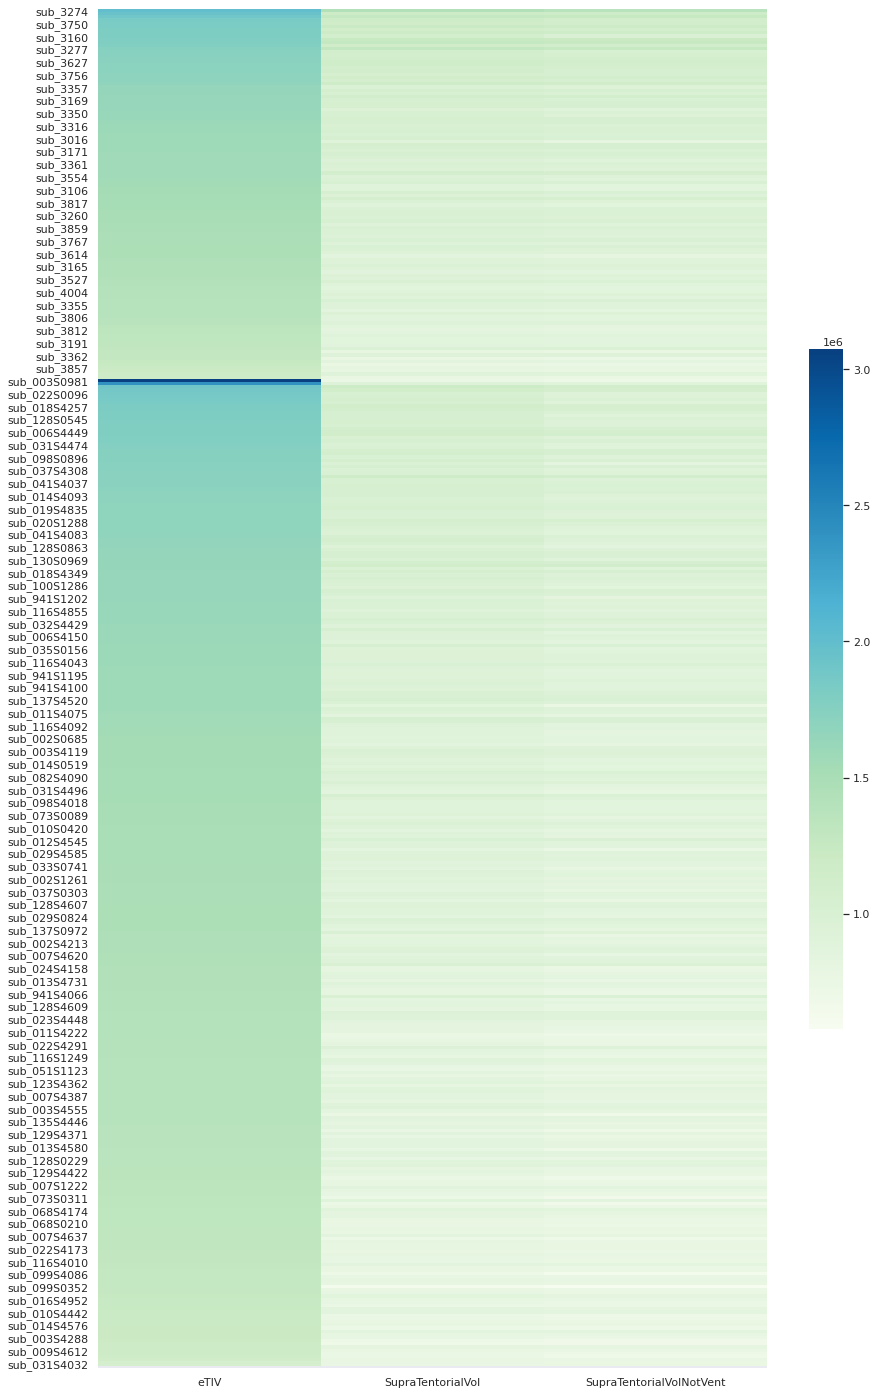

In [7]:
#suit_res_dfs[1].columns
plot_df = all_data['Des'].copy()
line_pos=len(plot_df[plot_df["group"]=='PPMI']);
plot_df = plot_df.sort_values(['group','eTIV','age'], ascending=False)
disp_col=['eTIV','SupraTentorialVol', 'SupraTentorialVolNotVent']
plot_df = plot_df[disp_col]
sns.set(font_scale=1)
with sns.axes_style("dark"):
    f, ax = plt.subplots(figsize=(15, 25))
    #sns.color_palette("cubehelix", as_cmap=True)
    g = sns.heatmap(plot_df,cbar_kws={"shrink": .5}, cmap="GnBu")
    plt.axvline(line_pos, ls='--',c='k')

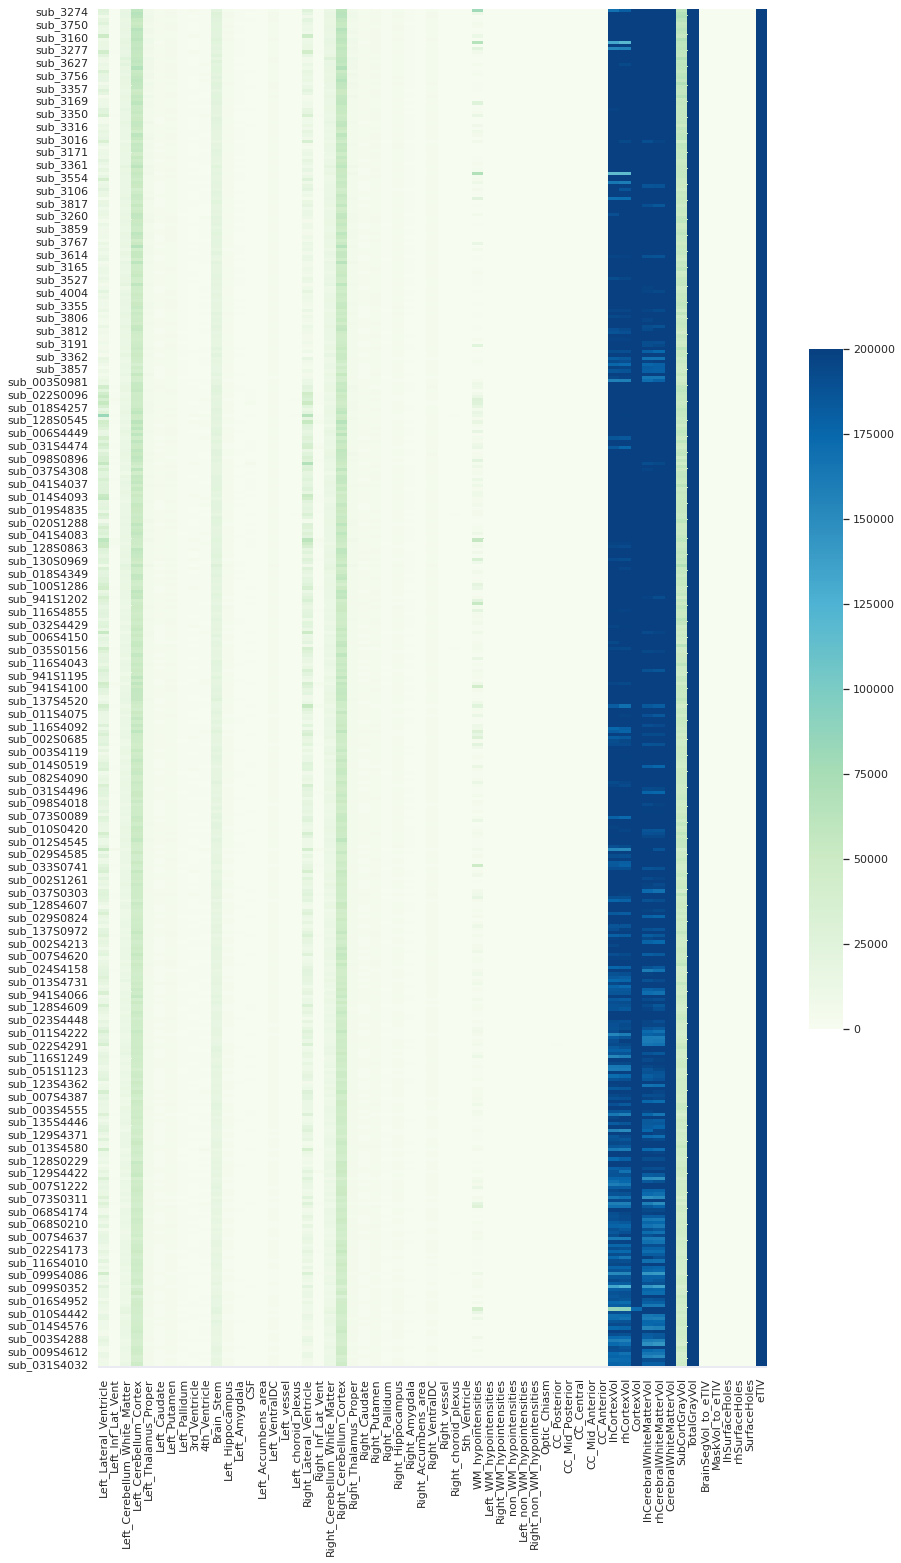

In [8]:
# QC for freesurfer results of ANDI and PPMI controls
#seg_col-['BrainSegVolNotVent', 'SupraTentorialVolNotVent', 'SupraTentorialVolNotVentVox']
vis_list=seg_col
plot_df = all_data['Des'].copy()
line_pos=len(plot_df[plot_df["group"]=='PPMI']);
[ vis_list.remove(x) for x in ['BrainSegVolNotVent', 'SupraTentorialVolNotVent', 'SupraTentorialVolNotVentVox', 'MaskVol','BrainSegVol','BrainSegVolNotVentSurf','SupraTentorialVol'] if x in vis_list ]
# sort by age
plot_df = plot_df.sort_values(['group','eTIV','age'], ascending=False)
plot_df = plot_df[vis_list]
sns.set(font_scale=1)
with sns.axes_style("dark"):
    f, ax = plt.subplots(figsize=(15, 25))
    #sns.color_palette("cubehelix", as_cmap=True)
    g = sns.heatmap(plot_df,cbar_kws={"shrink": .5}, cmap="GnBu",vmin=0, vmax=200000)
    plt.axvline(line_pos, ls='--',c='k')

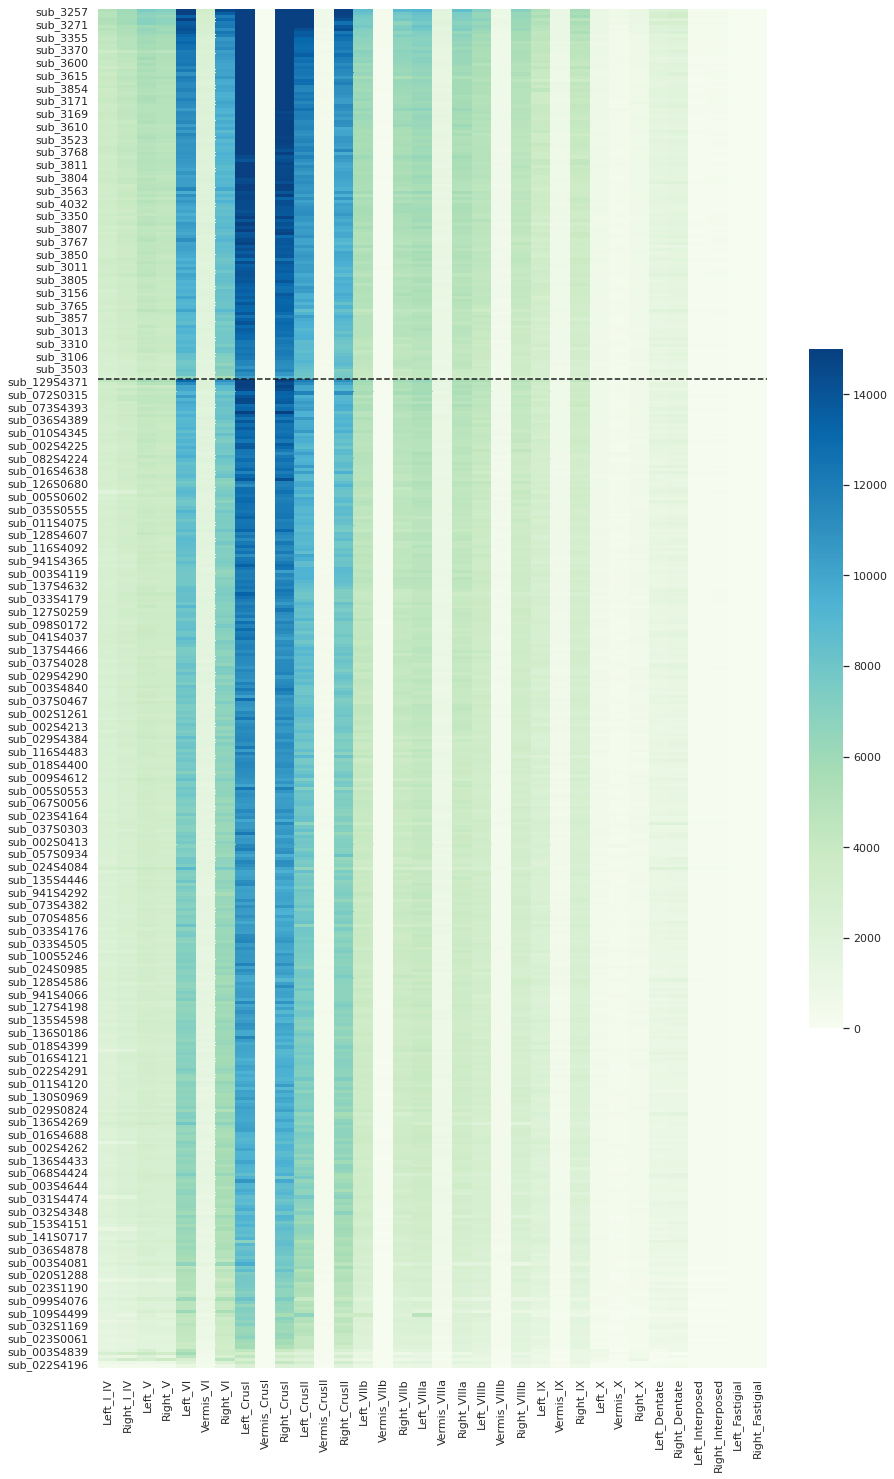

In [9]:
# QA PPMI and ADNI SUIT results.
plot_df = all_data['Des'].copy()
vis_list=SUIT_labels;
line_pos=len(plot_df[plot_df["group"]=='PPMI']);
# sort by age
plot_df = plot_df.sort_values(['group','suit_total','age'], ascending=False)
plot_df = plot_df[vis_list]
sns.set(font_scale=1)
with sns.axes_style("dark"):
    f, ax = plt.subplots(figsize=(15, 25))
    #sns.color_palette("cubehelix", as_cmap=True)
    g = sns.heatmap(plot_df,cbar_kws={"shrink": .5}, cmap="GnBu", vmin=0, vmax=15000) # , 
    plt.axhline(line_pos, ls='--', c='k')

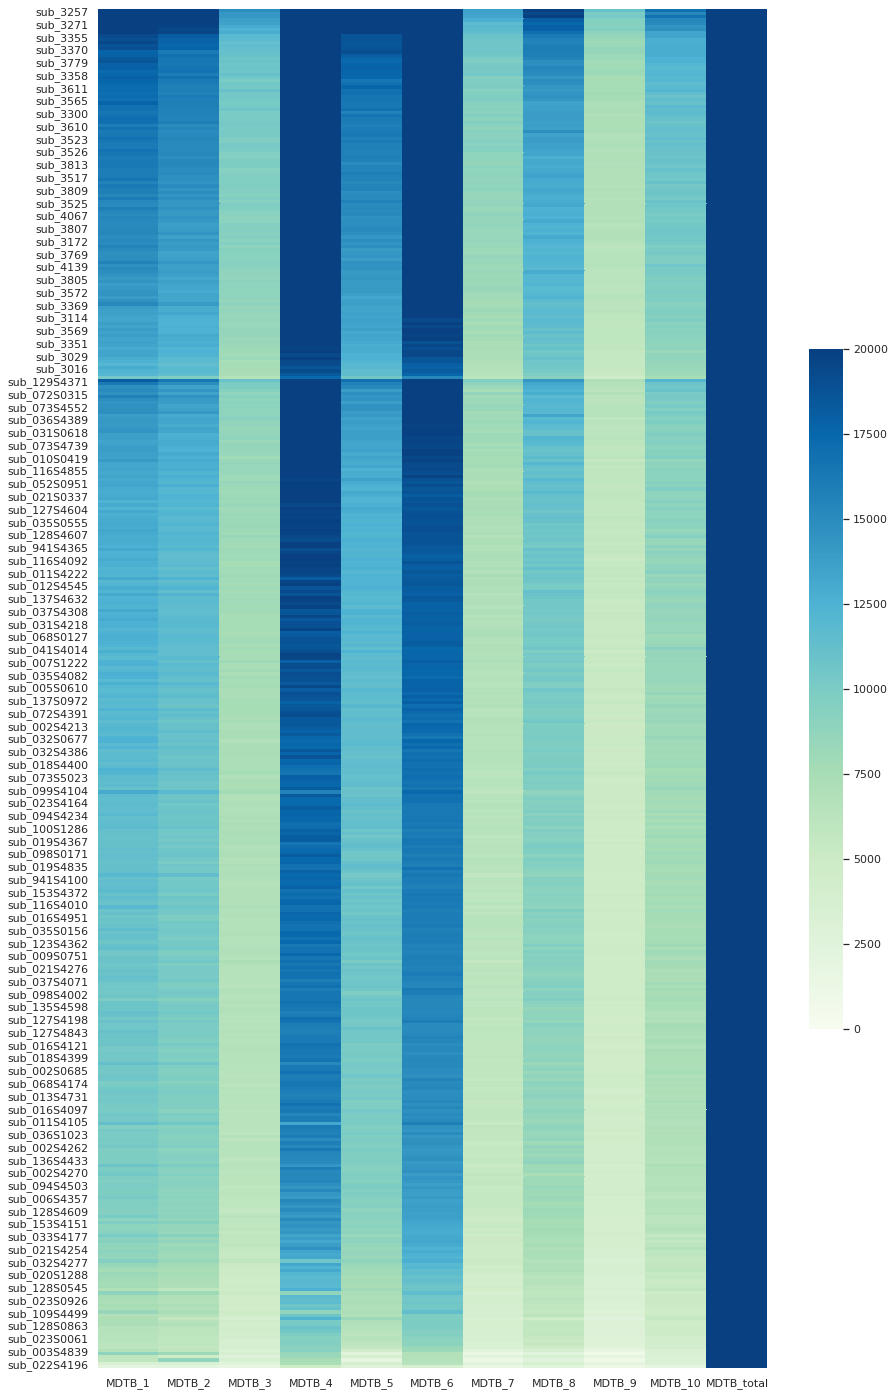

In [10]:
plot_df = all_data['DKT'].copy()
vis_list=mdtb_col;
# sort by age
plot_df = plot_df.sort_values(['group','MDTB_total','age'], ascending=False)
plot_df = plot_df[vis_list]
sns.set(font_scale=1)
with sns.axes_style("dark"):
    f, ax = plt.subplots(figsize=(15, 25))
    #sns.color_palette("cubehelix", as_cmap=True)
    g = sns.heatmap(plot_df,cbar_kws={"shrink": .5}, cmap="GnBu", vmin=0, vmax=20000)
    plt.axvline(len(lh_des_ct_col), ls='--',c='white')

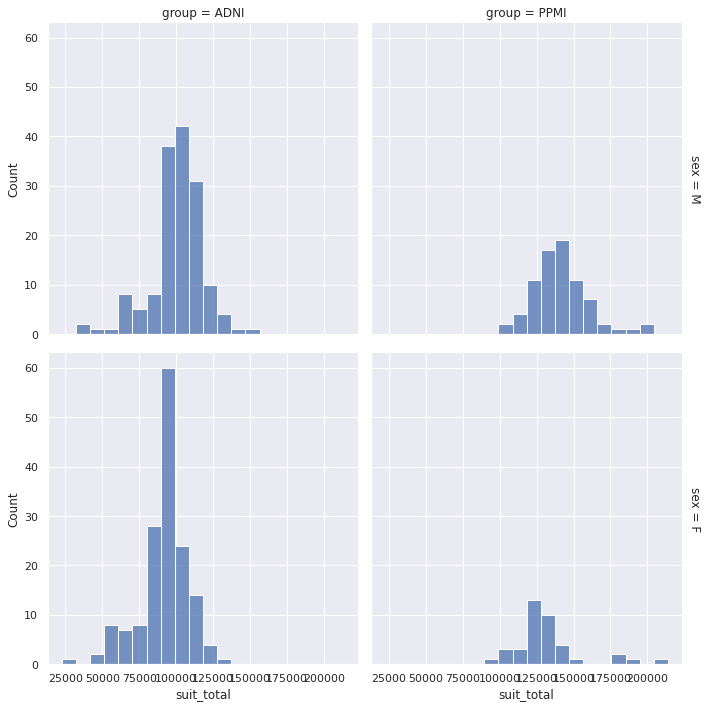

In [11]:
#display cerebellar lobular distribution
plot_df = all_data['DKT'].copy()
sns.set_theme(style="darkgrid")
sns.displot(plot_df, x="suit_total", col="group", row="sex", bins=20,facet_kws=dict(margin_titles=True))

In [12]:
# QA to get problematic 
plot_df = all_data['DKT'].copy()
suit_total_th=1000;
plot_df = plot_df[suit_col+['group','age','sex']]
plot_df['participant_id'] = plot_df.index
cere_small_df = plot_df[plot_df['Left_I_IV']<suit_total_th]
cere_small_df = cere_small_df.sort_values(['group','participant_id','suit_total'])

[display(x,len(cere_small_df[cere_small_df['group']==x].index), "\', \'".join([z.replace('_','-') for z in list(cere_small_df[cere_small_df['group']==x].index)]))
 for x in ['PPMI', 'ADNI']]
display(cere_small_df.sort_values('Left_I_IV', ascending=0).head(40))
# figure out the normal size range and re do: 

'PPMI'

0

''

'ADNI'

2

"sub-003S0981', 'sub-022S4196"

,Left_I_IV,Right_I_IV,Left_V,Right_V,Left_VI,Vermis_VI,Right_VI,Left_CrusI,Vermis_CrusI,Right_CrusI,...,Right_Dentate,Left_Interposed,Right_Interposed,Left_Fastigial,Right_Fastigial,suit_total,group,age,sex,participant_id
sub_022S4196,725,788,781,928,2291,456,2368,3943,3,4111,...,332,19,35,2,6,36748,ADNI,80,M,sub_022S4196
sub_003S0981,419,451,444,477,1261,339,1214,2472,4,2309,...,301,29,32,3,2,22545,ADNI,91,F,sub_003S0981


In [13]:
# save the new freesurfer resutls
# res_file = [data_dir/'ADNI-PPMI_Des-cere_preped.csv', data_dir/'ADNI-PPMI_DKT-cere_preped.csv']
all_data['Des'].to_csv(res_file[0])
all_data['DKT'].to_csv(res_file[1])

## Below is the codes that currently not in use.

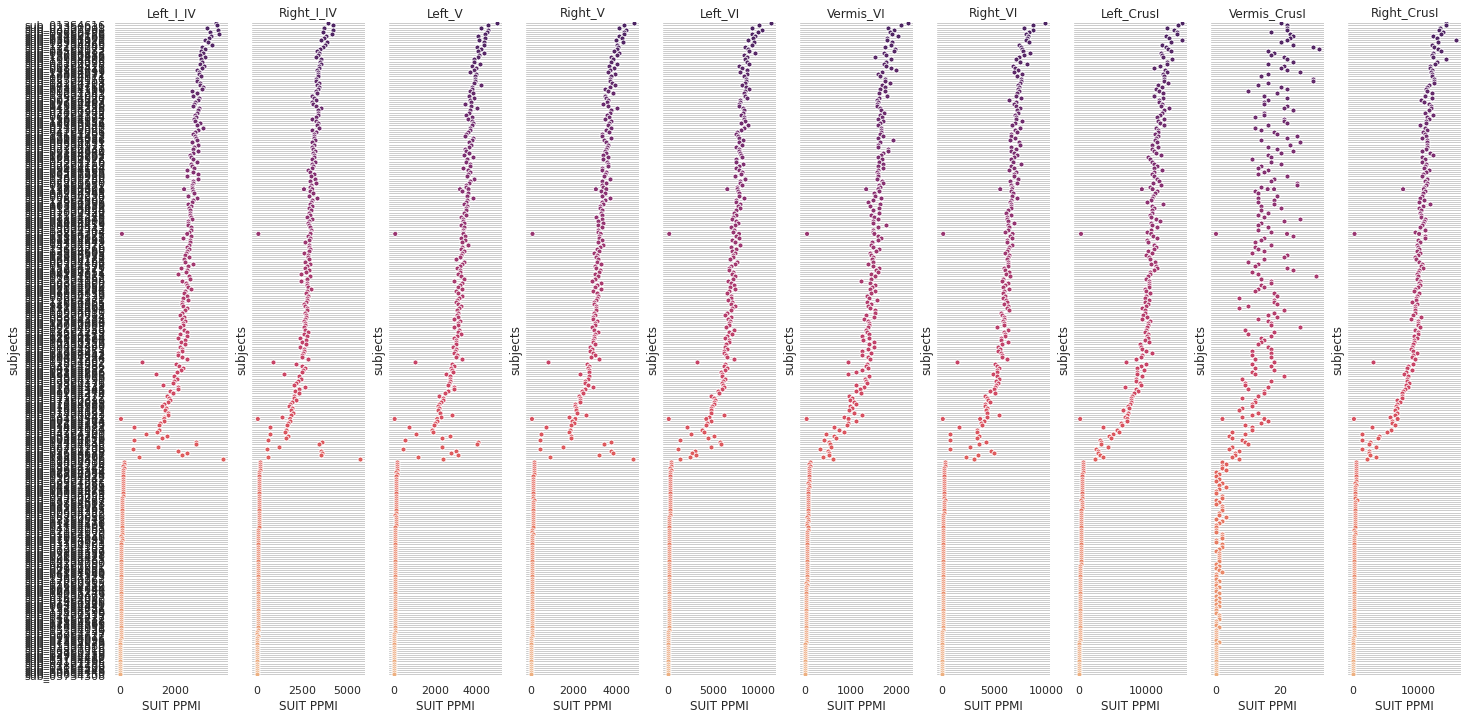

In [24]:
# visualzie check for PPMI and ADNI
visdf=suit_res_dfs[0].copy()
visdf['participant']=visdf.index
import seaborn as sns
sns.set_theme(style="whitegrid")
# Make the PairGrid
g = sns.PairGrid(visdf.sort_values("suit_total", ascending=False),
                 x_vars=visdf.columns[:10], y_vars=['participant'], height=10, aspect=.2)
# Draw a dot plot using the stripplot function
g.map(sns.stripplot, size=5, orient="h", jitter=False, palette="flare_r", linewidth=0.8, edgecolor="w")
# Use the same x axis limits on all columns and add better labels
g.set(xlabel="SUIT PPMI", ylabel="subjects")
# Use semantically meaningful titles for the columns
titles = visdf.columns[:10]
for ax, title in zip(g.axes.flat, titles):
    # Set a different title for each axes
    ax.set(title=title)
    # Make the grid horizontal instead of vertical
    ax.xaxis.grid(False)
    ax.yaxis.grid(True)
sns.despine(left=True, bottom=True)

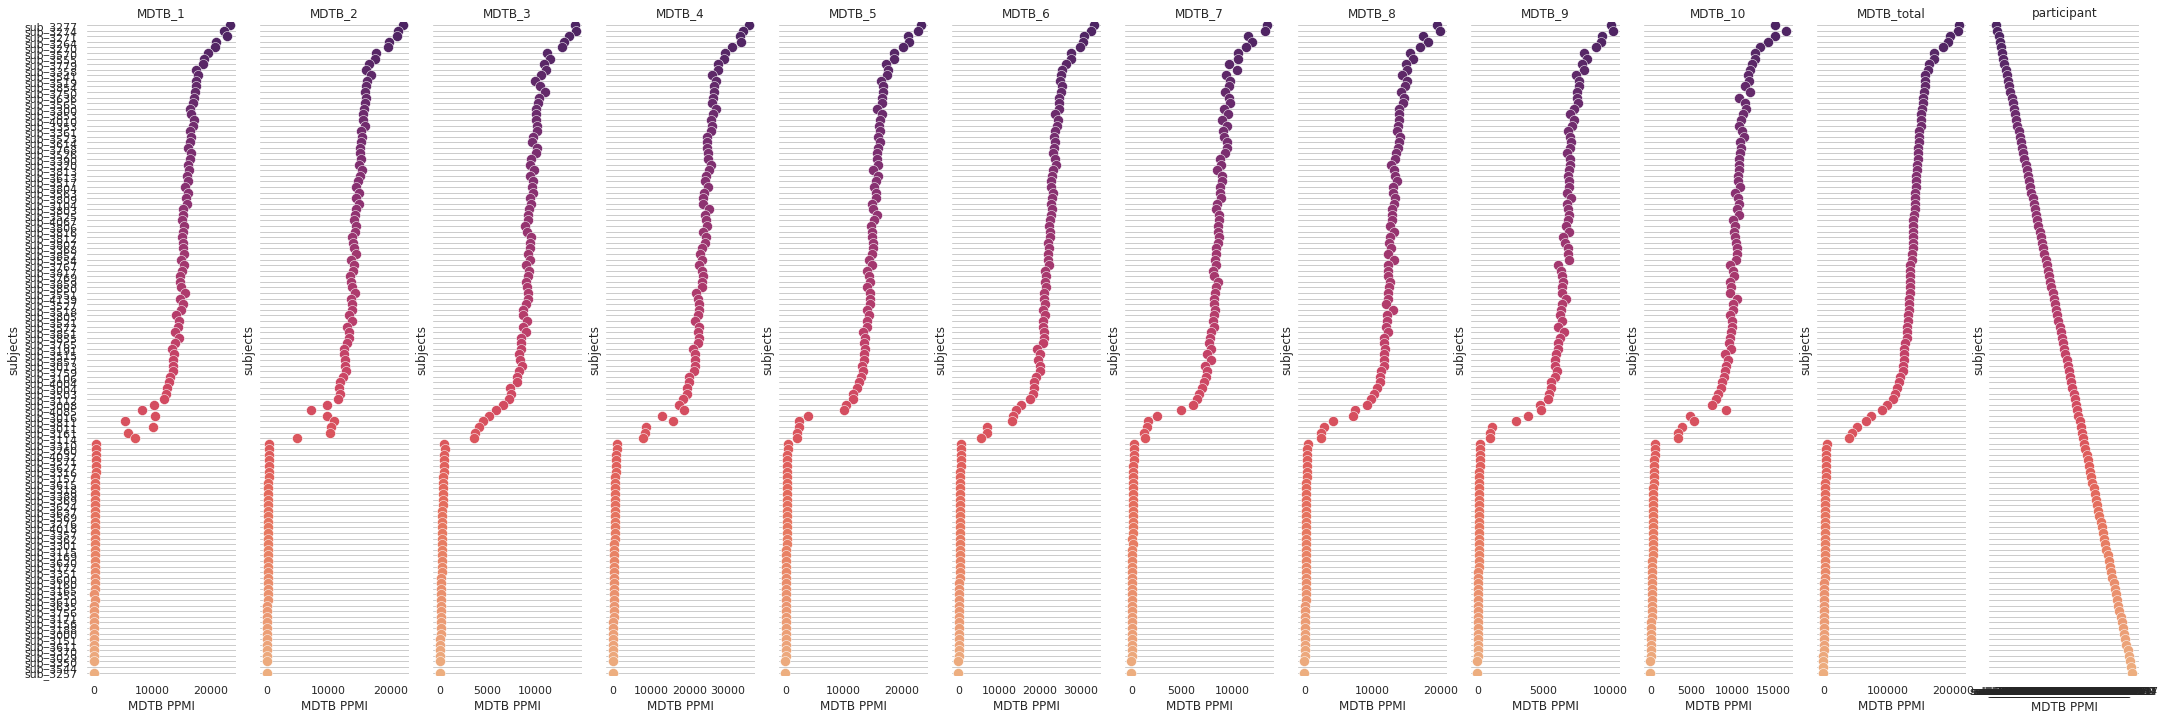

In [22]:
# visualzie check for PPMI and ADNI
visdf=MDTB_res_dfs[1].copy()
visdf['participant']=visdf.index
import seaborn as sns
sns.set_theme(style="whitegrid")
# Make the PairGrid
g = sns.PairGrid(visdf.sort_values("MDTB_total", ascending=False),
                 x_vars=visdf.columns, y_vars=['participant'], height=10, aspect=.25)
# Draw a dot plot using the stripplot function
g.map(sns.stripplot,size=10, orient="h", jitter=False, palette="flare_r", linewidth=0.5, edgecolor="w")
# Use the same x axis limits on all columns and add better labels
g.set(xlabel="MDTB PPMI", ylabel="subjects")
# Use semantically meaningful titles for the columns
titles = visdf.columns
for ax, title in zip(g.axes.flat, titles):
    # Set a different title for each axes
    ax.set(title=title)
    # Make the grid horizontal instead of vertical
    ax.xaxis.grid(False)
    ax.yaxis.grid(True)
sns.despine(left=True, bottom=True)

Index(['age', 'sex', 'group', 'Left-Lateral-Ventricle', 'Left-Inf-Lat-Vent',
       'Left-Cerebellum-White-Matter', 'Left-Cerebellum-Cortex',
       'Left-Thalamus-Proper', 'Left-Caudate', 'Left-Putamen',
       ...
       'MDTB_2', 'MDTB_3', 'MDTB_4', 'MDTB_5', 'MDTB_6', 'MDTB_7', 'MDTB_8',
       'MDTB_9', 'MDTB_10', 'MDTB_total'],
      dtype='object', length=482)

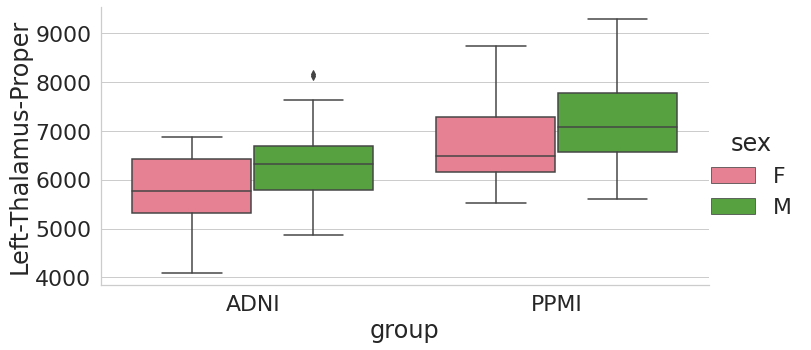

In [15]:
des_vis=all_data['Des'].copy()
display(des_vis.columns)
sns.set(font_scale=2)
palette = sns.color_palette('husl',3)
with sns.axes_style("whitegrid"):
    g = sns.catplot(y='Left-Thalamus-Proper', x='group', hue='sex', kind='box',aspect=2, height=5, palette = palette,
                    data=des_vis)
#    if normalize:
#        plt.ylabel('Volume (TBV %)')

In [26]:
#remove problematic subjects
#all_data=all_data.drop(index='sub_0073'); # only left brain NC
#all_data=all_data.drop(index='sub_0064'); # super large head normal control, NC
#all_data.columns

In [5]:
#save data
all_data['Des'].to_csv(res_file[0])
all_data['DKT'].to_csv(res_file[1])

In [19]:
# get data lists
from pathlib import Path
import os
import nipype.interfaces.spm.preprocess as preproc
import nipype.interfaces.spm.utils as spmu

os.chdir(r'/scratch/output/test_suit/PPMI_SUIT_res')
applymat = spmu.ApplyTransform()
applymat.inputs.in_file = 'sub-3000_run-1_desc-preproc_T1w.nii'
applymat.inputs.mat =  'Affine_sub-3000_run-1_desc-preproc_T1w_seg1.mat'
applymat.run()

OSError: No command "matlab" found on host e82ce52bfb8e. Please check that the corresponding package is installed.

In [9]:
data_dir.

'C:\\Users\\Vincent\\Desktop\\scratch\\output\\test_suit\\PPMI_SUIT_res'

In [ ]:
applydef = preproc.ApplyDeformations()
applydef.inputs.in_files = 'functional.nii'
applydef.inputs.deformation_field  = 'func_to_struct.mat'
applydef.inputs.reference_volume   = 'func_to_struct.mat'
applydef.run() 
